# Inference of Pydnet-Pytorch pretrained model on an image

Run inference on an image and display the output and test the runtime on local machine: Pytorch 1.7, CUDA 10.1 computer with GTX 2080 TI GPU, Tensorflow 2.4.0-dev.

Also optimize the model for faster inference using 

- [x] JIT from Pytorch
- [ ] Jit from NVIDIA (TrTorch)
- [x] Mobile optimizer of Pytorch  --> Runs on CPU but not on GPU
- [x] ONNX and it's optimizer
- [x] ONNX runtime
- [x] TensorRT
- [ ] TVM
- [x] Convert ONNX model to Tenseoflow and compare runtime. must have align_corners=True in upsample for this

Run this notebook interactively  [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/zshn25/Pydnet-Pytorch/c2262edb5b5f86bca5bc2c3bd25b11bd7f69c627?filepath=inference.ipynb)

## 1. Import libs, load model and example image

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch # v 1.6
import torchvision.transforms.functional as TF
from pydnet import PyddepthInference, Pydnet
import torch.utils.mobile_optimizer as mobile_optimizer
import numpy as np
import tensorflow as tf # 2.4.0-dev

device = "cpu"

print("Pytorch version:", torch.__version__, "\nTensorflow version:", tf.__version__)

Pytorch version: 1.7.0 
Tensorflow version: 2.4.0-dev20200913


Utility function to correctly time a torch model

In [2]:
def time_torch_model(model, input, use_cuda=True, print_time=False):
    """
    Times the forward pass of a nn.Module with the given input.
    Inputs:
    ---------
        model: nn-Module
        input: torch.Tensor
        use_cuda: bool       To use CUDA GPU or not (default: True)
        print_time: bool     Print the time?        (default: False)
    Output:
    ---------
        total_time_ms
    License: Zeeshan Khan Suri
    """
    model.eval()
    torch.cuda.synchronize()
    with torch.no_grad():
        with torch.autograd.profiler.profile(use_cuda=use_cuda) as prof:
            model(input)
    total_time_ms = sum([item.cuda_time for item in prof.function_events])/1000
    if print_time:
        print("{:.3f} ms".format(total_time_ms))
    return total_time_ms

def plot_input_output(img,output, print_output_shape=True):
    """
    Plots two images side-by-side.
    Inputs:
    -----------
        image1: PIL image or numpy array
        output: torch.Tensor or numpy array
    """
    if isinstance(output, torch.Tensor):
        output = output.to('cpu').detach().numpy()
    output = output.squeeze()
    
    if print_output_shape: print(output.shape)

    fig, axes = plt.subplots(1,2, figsize=(20,3))
    axes[0].imshow(img)
    depthmap=axes[1].imshow(output)
    fig.colorbar(depthmap);

### 1.1 Load an example input data to run experiments on

torch.Size([1, 3, 192, 640])


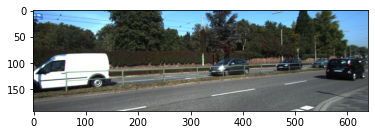

In [3]:
img1 = Image.open('test/1.png')
img1 = img1.resize((640, 192), Image.ANTIALIAS)
example1 = TF.to_tensor(img1).unsqueeze_(0).to(device)

example1_tf = example1.to('cpu').detach().numpy().astype(np.float32)
#example1_tf = np.transpose(example1_tf, [0, 2, 3, 1])
example1_tf.shape

print(example1.shape)
plt.imshow(img1);

### 1.2 Load the model

In [4]:
# bla=Pydnet(mobile_version=True, my_version=False)
# loaded_dict = torch.utils.model_zoo.load_url("https://github.com/zshn25/Pydnet-Pytorch/blob/forMonodepth2/mobile_pydnet.pth", 
#                                              map_location= lambda storage, loc: storage)

#bla.load_state_dict(loaded_dict)


In [5]:
pyddepth = PyddepthInference(mobile_version=True, my_version=False, pretrained=True)
pyddepth.to(device)
pyddepth.eval();

Run inference on baseline original model

40.6 ms ± 6.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(96, 320)


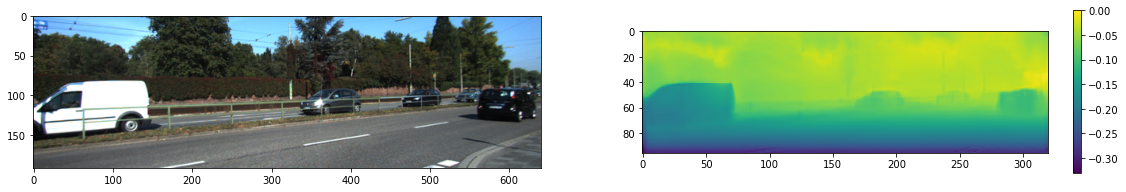

In [6]:
output=pyddepth(example1)

%timeit time_torch_model(pyddepth, example1, print_time=False, use_cuda="cuda" in device )

plot_input_output(img1, output)

---
## 2. Model Optimizations for faster inference

### 2.1 Model pruning

In [7]:
import torch.nn.utils.prune as prune

# Collect parameters to prune
parameters_to_prune = ()
for name, module in pyddepth.named_modules():
      if hasattr(module, "weight"):
        parameters_to_prune += ((module, 'weight'),)

In [8]:
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.35
)

for p,_ in parameters_to_prune:
    prune.remove(p, name="weight")

51.4 ms ± 6.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(96, 320)


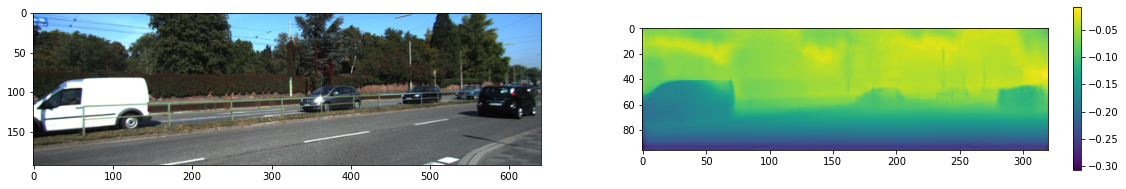

In [9]:
output=pyddepth(example1)

%timeit time_torch_model(pyddepth, example1, print_time=False, use_cuda="cuda" in device )

plot_input_output(img1, output)

In [10]:
# Verify the global sparsity
num=0;den=0
for name, module in pyddepth.named_modules():
      if hasattr(module, "weight"):
            num += torch.sum(module.weight == 0)
            den += module.weight.nelement()
            
print("Global sparsity: {:.2f}%".format(
        100. * float(num) / float(den)))

Global sparsity: 35.00%


In [11]:
torch.save(pyddepth, "mobile_pydnet_pruned35.pth")

### 2.2 FP16 quantization (Half precision)

34.2 ms ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(96, 320)


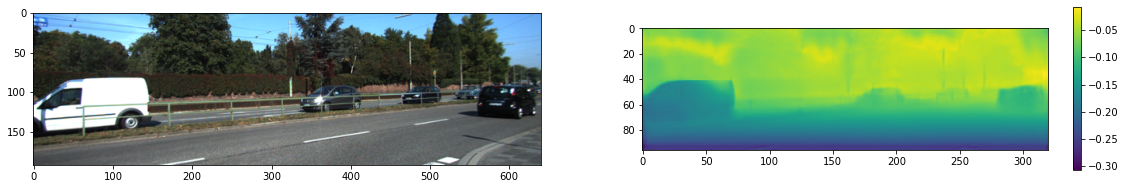

In [35]:
pyddepth_half = pyddepth.half()
example1_half = example1.half()

output=pyddepth_half(example1_half)

%timeit time_torch_model(pyddepth_half, example1_half, print_time=False, use_cuda="cuda" in device )

plot_input_output(img1, output.double())

### 2.3 Jit Trace

39.2 ms ± 2.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(96, 320)


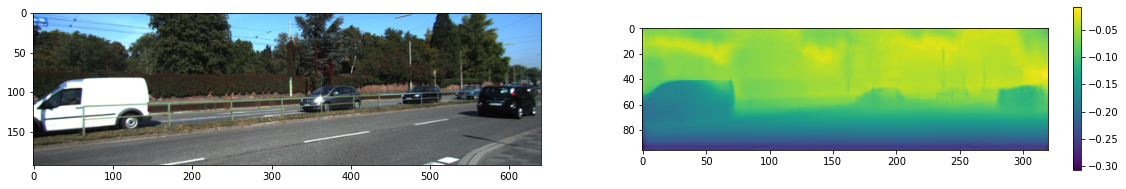

In [12]:
traced_model = torch.jit.trace(pyddepth, example1)

output=traced_model(example1)
%timeit time_torch_model(traced_model,example1, print_time=False, use_cuda="cuda" in device )

plot_input_output(img1, output)

In [13]:
#scripted_model = torch.jit.script(pyddepth, example1)
#%timeit scripted_model(example1)

JIT Traced model is faster than original model. Using JIT traced from now on.

### 2.4 Pytorch's mobile optimizer:

In [14]:
optimized_traced_model = mobile_optimizer.optimize_for_mobile(traced_model)

#%timeit time_torch_model(optimized_traced_model, example1, print_time=False, use_cuda="cuda" in device ) # check https://discuss.pytorch.org/t/runtimeerror-mobile-optimized-model-cannot-be-inferenced-on-gpu/94098

Pytorch's mobile optimizer optimizes the model to run on ARM CPU, but not on a GPU. So, when we try to run it on GPU, we get an error but if we try to run on GPU, it works

/home/e2r/anaconda3/envs/e2r/lib/python3.7/site-packages/torch/nn/modules/module.py:727: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729006826/work/c10/core/TensorImpl.h:848.)
  result = self.forward(*input, **kwargs)


(96, 320)


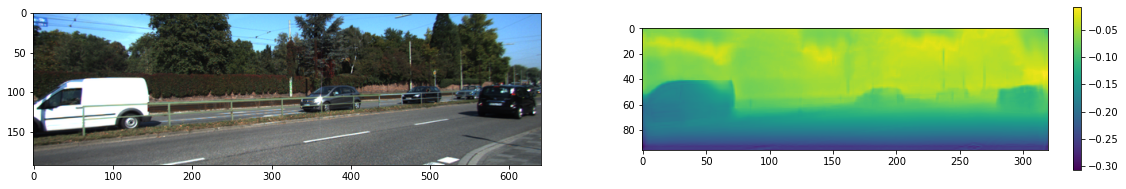

In [15]:
output=mobile_optimizer.optimize_for_mobile(traced_model.to("cpu"))(example1.to("cpu"))
plot_input_output(img1,output)
traced_model.to(device);

---

## 3 Model conversions

### 3.1 ONNX

In [16]:
# Export model. 
# Using opset version 11 as the model contains nn.Upsample (which is supported by opset version >=11)
onnx_model = torch.onnx.export(traced_model,               # model being run
                              example1,                         # model input (or a tuple for multiple inputs)
                              "mobile_pydnet.onnx",   # where to save the model (can be a file or file-like object)
                              example_outputs=output,
                              export_params=True,        # store the trained parameter weights inside the model file
                              opset_version=11,          # the ONNX version to export the model to
                              keep_initializers_as_inputs=True,
                              do_constant_folding=True,  # whether to execute constant folding for optimization
                              input_names = ['input'],   # the model's input names
                              output_names = ['output'], # the model's output names
                              dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                            'output' : {0 : 'batch_size'}})

In [17]:
# ONNXRuntime-GPU requires CUDA 10.1
#!pip install onnxruntime
#!conda install -c conda-forge onnx --yes
import onnx
import onnxruntime as ort

print("ONNX version:", onnx.__version__, "\nONNX Runtime version:", ort.__version__)

ONNX version: 1.7.0 
ONNX Runtime version: 1.4.0


In [18]:
model = onnx.load("mobile_pydnet.onnx")

# Check that the IR is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
#onnx.helper.printable_graph(model.graph)


Model visualization

In [19]:
#!pip install netron

In [20]:
import netron
#netron.start("mobile_pydnet.onnx")

#### 3.1.2 ONNX Optimizer: See [this](https://github.com/onnx/onnx/blob/master/docs/PythonAPIOverview.md#optimizing-an-onnx-model)

In [21]:
from onnx import optimizer

onnx.checker.check_model(model)
onnx.helper.strip_doc_string(model)
optimized_model = onnx.shape_inference.infer_shapes(model)

optimizers_list = ['eliminate_deadend', 'eliminate_nop_dropout',
                                            'eliminate_nop_monotone_argmax', 'eliminate_nop_pad',
                                            'extract_constant_to_initializer', 'eliminate_unused_initializer',
                                            'eliminate_nop_transpose', 
                                            # disable this optimizer until https://github.com/onnx/optimizer/issues/3 gets fixed
                                            'fuse_add_bias_into_conv',
                                            'fuse_consecutive_concats',
                                            'fuse_consecutive_log_softmax',
                                            'fuse_consecutive_reduce_unsqueeze', 'fuse_consecutive_squeezes',
                                            'fuse_consecutive_transposes', 'fuse_matmul_add_bias_into_gemm',
                                            'fuse_pad_into_conv', 'fuse_transpose_into_gemm']
optimized_model = optimizer.optimize(optimized_model, optimizers_list,#optimizer.get_available_passes(),
                                     fixed_point=True)
onnx.checker.check_model(optimized_model)

onnx.save(optimized_model, "optimized_mobile_pydnet.onnx")

52 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(96, 320)


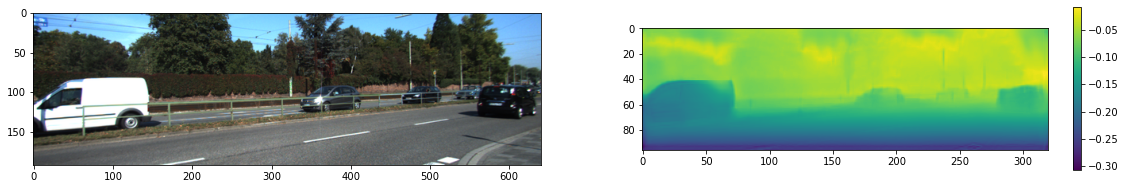

In [22]:
import numpy as np
ort_input = example1.to('cpu').detach().numpy().astype(np.float32)

ort_session = ort.InferenceSession('optimized_mobile_pydnet.onnx')

#print("This is on CPU as ONNXRuntime is on CPU")
outputs = ort_session.run(None,  {ort_session.get_inputs()[0].name: ort_input})[0]

%timeit ort_session.run(None,  {ort_session.get_inputs()[0].name: ort_input})[0]

plot_input_output(img1, outputs)


In [23]:
## Pytorch to Keras
#!pip install onnx2keras
# from onnx2keras import onnx_to_keras
# k_model = onnx_to_keras(onnx_model=model, input_names=['input'])

### 3.2 Convert to Tensorflow

In [24]:
model = onnx.load("optimized_mobile_pydnet.onnx")

In [25]:
#!pip install tensorflow --force-reinstall
#!pip install tensorflow-addons
# Install onnx-tensorflow as follows in terminal
#!pip uninstall onnx-tf --yes
#!pip install git+https://github.com/onnx/onnx-tensorflow.git
#!git clone https://github.com/onnx/onnx-tensorflow.git && cd onnx-tensorflow
#!pip install -e .

In [26]:
from onnx_tf.backend import prepare
import onnx
#model = onnx.load("mobile_pydnet_interp.onnx")

tf_rep = prepare(model)

# Input nodes to the model
print('inputs:', tf_rep.inputs)

# Output nodes from the model
print('outputs:', tf_rep.outputs)

# All nodes in the model
print('tensor_dict:')
print(tf_rep.tensor_dict)

inputs: ['input']
outputs: ['output']
tensor_dict:
{}


/home/e2r/anaconda3/envs/e2r/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:44: UserWarning: You are currently using a nightly version of TensorFlow (2.4.0-dev20200913). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


Tensorflow supports inputs in the format `NHWC` but our inputs are in the format `NCHW`. So, we change our input shape as follows

This is on CPU as ONNXRuntime is on CPU
78.3 ms ± 7.19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(96, 320)
INFO:tensorflow:Assets written to: mobile_pydnet_pruned35/assets


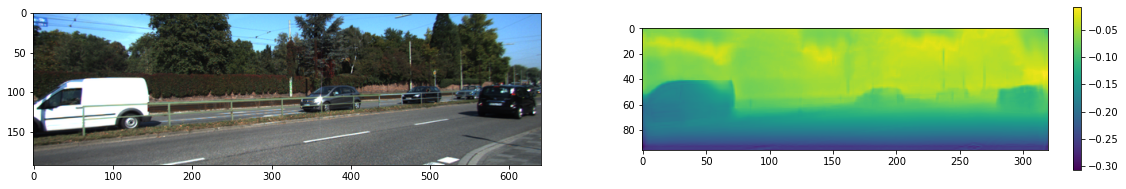

In [27]:
print("This is on CPU as ONNXRuntime is on CPU")
%timeit tf_rep.run(example1_tf)

output1 = tf_rep.run(example1_tf)[0].squeeze()
plot_input_output(img1, output1)

# # export tensorFlow backend to tensorflow tf file
tf_rep.export_graph('mobile_pydnet_pruned35/')

The above was using ONNX for inference. Next we will use Tensorflow for inference

101 ms ± 9.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(96, 320)


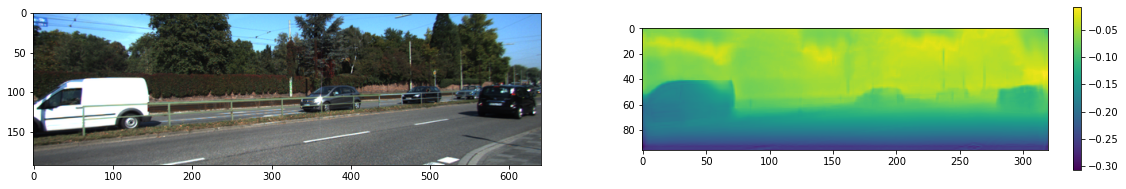

In [28]:
# Inference using Tensorflow # must be v2

# Run inference on SavedModel using Tensorflow
imported = tf.saved_model.load("mobile_pydnet_pruned35/") # tf.keras.models.load_model('mobile_pydnet_pruned35')
output1 = imported(input=example1.to('cpu').detach().numpy().astype(np.float32))[0].numpy().squeeze()

%timeit imported(input=example1_tf)

plot_input_output(img1, output1)

In [29]:
## Tensorflo model optimization
# from tensorflow.python.tools import optimize_for_inference_lib
# input_graph_def = graph_pb2.GraphDef()
# output_graph_def = optimize_for_inference_lib.optimize_for_inference(

#       input_graph_def,
#       FLAGS.input_names.split(","),
#       FLAGS.output_names.split(","), FLAGS.placeholder_type_enum)

### 3.3 Convert to Tensorflow Lite

In [30]:
# tf.executing_eagerly()
converter = tf.lite.TFLiteConverter.from_saved_model("mobile_pydnet_pruned35")
converter.experimental_new_converter = True
converter.experimental_new_quantizer = True
converter.allow_custom_ops = True
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS,
                                      tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.target_spec.supported_types = [tf.int8]
# converter.inference_input_type = tf.int8  # or tf.int8
# converter.inference_output_type = tf.int8  # or tf.int8
# converter.representative_dataset = lambda : [example1_tf]
tflite_model = converter.convert()

with tf.io.gfile.GFile('mobile_pydnet_pruned35.tflite', 'wb') as f:
    f.write(tflite_model)

[  1   3 192 640]
11.9 s ± 403 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
done
(96, 320)


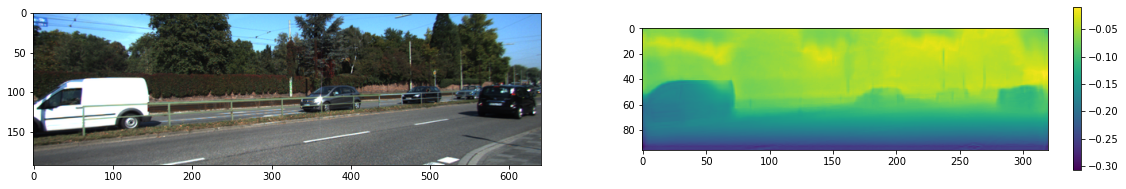

In [31]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="mobile_pydnet_pruned35.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']
#input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32) # example1.to('cpu').detach().numpy().astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], example1_tf)

print(input_shape)
%timeit interpreter.invoke()
print("done")
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.

output1 = interpreter.get_tensor(output_details[0]['index']).squeeze()

plot_input_output(img1, output1)

**Note**: Although the above model is converted to tflite, it is not supported by Google Coral TPU, because to support on that hardware, it was necessary to quantize the model to int8 but I couldn't.

### 3.4 Convert to TensorRT

Install [TensorRT](https://docs.nvidia.com/deeplearning/tensorrt/install-guide/index.html) and [torch2trt](https://github.com/NVIDIA-AI-IOT/torch2trt)

In [ ]:
from torch2trt import torch2trt

model_trt = torch2trt(pyddepth, [example1])
output=model_trt(example1)

%timeit time_torch_model(model_trt,example1, print_time=False, use_cuda="cuda" in device )

plot_input_output(img1, output)

Half precision TensorRT

In [ ]:
model_trt = torch2trt(pyddepth.half(), [example1.half()])
output=model_trt(example1.half(), fp16_mode=True)

#%timeit time_torch_model(model_trt, example1, print_time=False, use_cuda="cuda" in device )

plot_input_output(img1, output.double())

___
### Legacy code

In [ ]:
# Convert from pb to SavedModel

import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import tag_constants
export_dir = 'saved_nopad'
graph_pb = 'mobile_pydnet_pruned35/saved_model.pb'

# builder = tf.saved_model.builder.SavedModelBuilder(export_dir)

with tf.gfile.GFile(graph_pb, "rb") as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

sigs = {}
with tf.Session(graph=tf.Graph()) as sess:
    tf.import_graph_def(graph_def, name="")
    g = tf.get_default_graph()
    inp = g.get_tensor_by_name('input:0')
    out = g.get_tensor_by_name("output:0")

#     sigs[signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY] = \
#         tf.compat.v1.saved_model.signature_def_utils.predict_signature_def(
#             {"input": inp}, {"output": out})

#     builder.add_meta_graph_and_variables(sess,
#                                          [tag_constants.SERVING],
#                                          signature_def_map=sigs)
#     builder.save()
    #input_tensor_shape = sess.graph.get_tensor_by_name('input:0').shape.as_list()
    output = sess.run(out, {"input:0": example1.to('cpu').detach().numpy()}) # --> Inference
    
    g.finalize()


#converter = tf.lite.TFLiteConverter.from_saved_model("saved")
#tflite_model = converter.convert()
    
#     [n.name for n in tf.get_default_graph().as_graph_def().node]

# for i in tf.get_default_graph().get_operations():
#     print(i)
# print(tf.get_default_graph())

In [ ]:
plt.imshow(output.squeeze())

In [ ]:
model.test(data = x_test)

In [ ]:
#tf.enable_control_flow_v2()
converter = tf.lite.TFLiteConverter.from_frozen_graph('mobile_pydnet_pruned35.pb', #TensorFlow freezegraph .pb model file
                                                      input_arrays=['input'], # name of input arrays as defined in torch.onnx.export function before.
                                                      output_arrays=['output']  # name of output arrays defined in torch.onnx.export function before.
                                                      )
#converter.experimental_new_converter = True
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

# tell converter which type of optimization techniques to use
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# to view the best option for optimization read documentation of tflite about optimization
# go to this link https://www.tensorflow.org/lite/guide/get_started#4_optimize_your_model_optional

# convert the model 
tf_lite_model = converter.convert()

In [ ]:
func = tf.saved_model.load('.')
#.signatures["serving_default"] 
out = func( tf.constant(10,tf.float32) )

In [ ]:
with tf.compat.v1.gfile.GFile('mobile_pydnet_pruned35.pb', "rb") as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())
with tf.Graph().as_default() as graph:
    tf.import_graph_def(graph_def, name='')
    tf.io.write_graph(graph_def, 'tmp/', 'hashtable.pbtxt')
    
#data_input = tf.placeholder(name='input', dtype=tf.float32, shape=[None, 192, 640, 3])
inpu = tf.get_default_graph().get_tensor_by_name("input:0")
emb = tf.get_default_graph().get_tensor_by_name("embeddings:0")
phase = tf.get_default_graph().get_tensor_by_name("phase_train:0")
tf.saved_model.simple_save(sess,"..\\teste_model_2\\",inputs={"input":inpu,"phase":phase},outputs={"output":emb})

In [ ]:
model = tf.saved_model.load(".")
concrete_func = model.signatures[
  tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 192, 640, 3])
converter = TFLiteConverter.from_concrete_functions([concrete_func])

In [ ]:
model

In [ ]:
#graph_def = tf.get_default_graph().as_graph_def()

with tf.control_dependencies([tf.compat.v1.initializers.tables_initializer()]):
      input_int64_tensor = tf.compat.v1.placeholder(tf.int64, shape=[1])
      input_string_tensor = tf.compat.v1.placeholder(tf.string, shape=[1])
      out_string_tensor = int64_to_string_table.lookup(input_int64_tensor)
      out_int64_tensor = string_to_int64_table.lookup(input_string_tensor)

converter = tf.lite.TFLiteConverter(graph,
                                  [input_int64_tensor, input_string_tensor],
                                  [out_string_tensor, out_int64_tensor])

supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter.target_spec.supported_ops = supported_ops
converter.allow_custom_ops = True
tflite_model = converter.convert()

In [ ]:

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(graph)
frozen_func.graph.as_graph_def()

In [ ]:
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph('mobile_pydnet_pruned35.pb', #TensorFlow freezegraph .pb model file
                                                      input_arrays=['input'], # name of input arrays as defined in torch.onnx.export function before.
                                                      output_arrays=['output']  # name of output arrays defined in torch.onnx.export function before.
                                                      )
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [ ]:
model = tf.saved_model.load(os.path.join(cwd,"mobile_pydnet_pruned35.pb"))
concrete_func = model.signatures[
  tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
concrete_func.inputs[0].set_shape([1, 192, 640, 3])
converter = TFLiteConverter.from_concrete_functions([concrete_func])

In [ ]:
# Convert the model to Tensorflow Lite.
converter = tf.lite.TFLiteConverter.from_saved_model('mobile_pydnet_pruned35.pb')
tflite_model = converter.convert()